In [64]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from data_normalizer import unscale_data_with_minmax
from sklearn.metrics import make_scorer

In [76]:

filtered_data = np.load('./macroeconomic_data/filtered_data.npy', allow_pickle=True).item()

data = []

for date, data_frame in filtered_data.items():
    flattened_data = pd.json_normalize(data_frame, sep=".")
    flattened_data["10"] = str(date[1])
    data.append(flattened_data)

data = pd.concat(data, ignore_index=True)

X = data
X = X.iloc[1:, :]

y = data.filter(regex='0.36', axis=1)  # '^0\.'
y = y.iloc[:-1]
y = y.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  # TODO: dodać walidujace


In [66]:
base_estimator = MLPRegressor()
parameters = {'hidden_layer_sizes': [(200, 200, 200, 200, 200), (200,200,200,200), (100, 200, 200, 100), (200,200,200)],
              "activation": ['logistic', 'tanh'],
              "solver": ['sgd'], "alpha": [0.001, 0.0001, 0.00005],
              "learning_rate": ['invscaling', 'adaptive'],
              'max_iter': [100000], #'early_stopping': [True],
              'tol': [1e-6], 'momentum' : [0.8, 0.85, 0.9, 0.95], 'nesterovs_momentum': [True, False]
              #'validation_fraction': [0.1, 0.2, 0.3]
              }


In [67]:

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

clf = GridSearchCV(base_estimator, param_grid=parameters, cv=5, error_score='raise', n_jobs=-1, verbose=2, scoring=mse_scorer)
clf.fit(X_train, y_train)

best_estimator = clf.best_estimator_


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200, 200, 200, 200, 200), learning_rate=invscaling, max_iter=100000, momentum=0.8, nesterovs_momentum=True, solver=sgd, tol=1e-06; total time=  15.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200, 200, 200, 200, 200), learning_rate=invscaling, max_iter=100000, momentum=0.85, nesterovs_momentum=False, solver=sgd, tol=1e-06; total time=   7.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200, 200, 200, 200, 200), learning_rate=invscaling, max_iter=100000, momentum=0.9, nesterovs_momentum=True, solver=sgd, tol=1e-06; total time=   6.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200, 200, 200, 200, 200), learning_rate=invscaling, max_iter=100000, momentum=0.9, nesterovs_momentum=False, solver=sgd, tol=1e-06; total time=   2.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200, 200, 200, 200

MLPRegressor(activation='tanh', alpha=0.001,
             hidden_layer_sizes=(100, 200, 200, 100), learning_rate='adaptive',
             max_iter=100000, momentum=0.85, nesterovs_momentum=False,
             solver='sgd', tol=1e-06)
{'mean_fit_time': array([26.897298  , 20.58899698, 13.89085622, 10.65039353,  3.79950991,
        3.23844237,  0.51739898,  0.42186589,  1.17792549,  0.94382248,
        1.10101051,  0.93226509,  0.83431201,  0.90157952,  1.12495027,
        0.77727585, 20.05584416, 15.2642879 , 14.36346169, 12.93077755,
        3.49901886,  3.60753527,  0.3008769 ,  0.31395373,  0.78988895,
        0.78404131,  0.6251092 ,  0.66937728,  0.65052123,  0.65755801,
        0.68657937,  0.63806124, 39.46857033, 21.87197275, 19.84901452,
       15.02576547,  8.34532747,  4.77267122,  0.86713147,  0.86705294,
        0.56169448,  0.60051656,  0.55574617,  0.55645375,  0.5267221 ,
        0.51774435,  0.4975358 ,  0.56895628, 18.52482972, 15.66465492,
        5.04289021,  5.54763

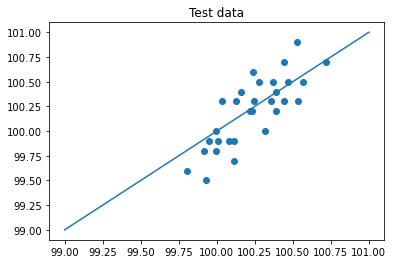

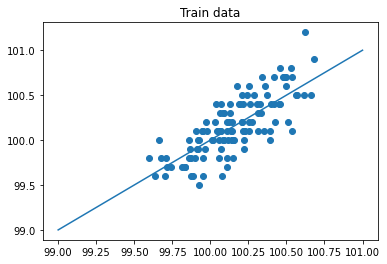

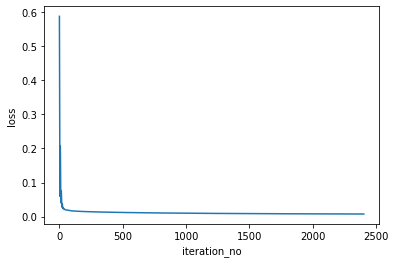

ValueError: x, y, and format string must not be None

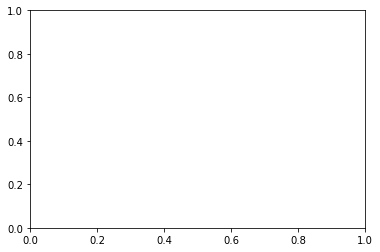

In [77]:

print(best_estimator)
print(clf.cv_results_)
y_pred = clf.predict(X_test)

y_pred_scaled = unscale_data_with_minmax(np.array(y_pred))
y_test_scaled = unscale_data_with_minmax(np.array(y_test))

# Print the predicted and actual values side by side
print("Predicted\tActual")
for pred, actual in zip(y_pred_scaled, y_test_scaled):
    print(f"{pred}\t\t{actual}")

mse = mean_squared_error(y_test_scaled, y_pred_scaled)
r2 = r2_score(y_test_scaled, y_pred_scaled)
print('Mean Squared Error:', mse)
print('R-squared Score:', r2)

plt.scatter(y_pred_scaled, y_test_scaled)
plt.plot([99, 101], [99, 101])
plt.title("Test data")
plt.show()

y_train_scaled = unscale_data_with_minmax(y_train)
y_train_pred = unscale_data_with_minmax(clf.predict(X_train))
plt.scatter(y_train_pred, y_train_scaled)
plt.plot([99, 101], [99, 101])
plt.title("Train data")
plt.show()

plt.figure()
plt.plot(best_estimator.loss_curve_)
plt.xlabel("iteration_no")
plt.ylabel("loss")
plt.show()

plt.figure()
plt.plot(best_estimator.validation_scores_)
plt.xlabel("iteration_no")
plt.ylabel("validation")
plt.show()
